<a href="https://colab.research.google.com/github/akankshakusf/Project-Fine-Tuned-LLMs-for-Product-Pricing/blob/master/ProprietaryModel_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict Product Prices

In [2]:
# pip installs
!pip install -q datasets \
                requests \
                torch \
                peft \
                bitsandbytes \
                transformers \
                trl \
                accelerate \
                sentencepiece\
                tiktoken \
                matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.0 MB/s eta 0:00:00


In [3]:
#import packages
import os
import re
import tqdm
import math
from google.colab import userdata
from huggingface_hub import login
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig,\
                                  TrainingArguments, set_seed
from peft import LoraConfig, PeftModel
from datasets import load_dataset, Dataset, DatasetDict
from datetime import datetime
import matplotlib.pyplot as plt


In [4]:
#tokenizers
LLAMA_3_1 = "meta-llama/Meta-Llama-3.1-8B"
QWEN_2_5 = "Qwen/Qwen2.5-7B"
GEMMA_2 = "google/gemma-2-9b"
PHI_3 = "microsoft/Phi-3-medium-4k-instruct"

#constants
BASE_MODEL = LLAMA_3_1
HF_USER = "akankshakusf"
DATASET_NAME = f"{HF_USER}/pricer-data"
MAX_SEQUENCE_LENGTH = 182
QUANT_4_BIT = True

# Used for writing to output in color
GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

%matplotlib inline

In [5]:
# Log in to HuggingFace
hf_token = userdata.get('HF_TOKEN')
login(hf_token, add_to_git_credential=True)

In [6]:
def investigate_tokenizer(model_name):
  print("Investigating tokenizers for", model_name)
  #initialize the tokenizer from hugging face
  tokenizer=AutoTokenizer.from_pretrained(model_name, trust_remote_code= True)

  #testing for below numbers
  for number in [0,1,10,100,999,1000]:
    #run tokenizer
    tokens=tokenizer.encode(str(number), add_special_tokens= False)
    print(f"The tokens for {number}:{tokens}")

In [8]:
# Now we will try this with each model: LLAMA_3_1, QWEN_2_5, GEMMA_2, PHI_3
print(investigate_tokenizer(LLAMA_3_1))
print(investigate_tokenizer(QWEN_2_5))
print(investigate_tokenizer(PHI_3))

Investigating tokenizers for meta-llama/Meta-Llama-3.1-8B
The tokens for 0:[15]
The tokens for 1:[16]
The tokens for 10:[605]
The tokens for 100:[1041]
The tokens for 999:[5500]
The tokens for 1000:[1041, 15]
None
Investigating tokenizers for Qwen/Qwen2.5-7B
The tokens for 0:[15]
The tokens for 1:[16]
The tokens for 10:[16, 15]
The tokens for 100:[16, 15, 15]
The tokens for 999:[24, 24, 24]
The tokens for 1000:[16, 15, 15, 15]
None
Investigating tokenizers for microsoft/Phi-3-medium-4k-instruct
The tokens for 0:[29871, 29900]
The tokens for 1:[29871, 29896]
The tokens for 10:[29871, 29896, 29900]
The tokens for 100:[29871, 29896, 29900, 29900]
The tokens for 999:[29871, 29929, 29929, 29929]
The tokens for 1000:[29871, 29896, 29900, 29900, 29900]
None


As you can see:
- In **LLaMA 3.1**, numbers up to **3 digits** are tokenized as **a single token**, and 4-digit numbers like `1000` are split into only **two tokens**.
- In contrast, **Qwen2.5** tends to tokenize **digit by digit**, even for simple numbers like `10` or `100`, resulting in longer sequences.
- And similar for others

---

This behavior is one of the reasons I'm leaning toward using **LLaMA 3.1** for my project. Since the goal is to **infer product prices** (a regression problem), having compact token representations for numeric values (especially 2–3 digit prices) provides several advantages:

- **Shorter and cleaner token sequences**
- **Faster inference and training times**
- **Better numerical representation and learning efficiency**

This makes `Meta-Llama-3.1-8B` a strong candidate for tasks involving numerical reasoning, such as **price prediction**.


In [24]:
# Loading My Data from Hugging Face
dataset=load_dataset(DATASET_NAME)
train= dataset['train']
test = dataset['test']

In [10]:
train[0]

{'text': 'How much does this cost to the nearest dollar?\n\nStar Micronics USB Thermal Receipt Printer with Device and Mfi USB Ports, Auto-cutter, and Internal Power Supply - Gray (Renewed)\nHigh-speed printing of 43 receipts per minute with easy to setup USB connection - just Plug and Print; USB serial number feature means the PC will detect the on its Windows platform using any USB port Includes PromoPRNT promotion printing service allowing you to automatically create printed promotions in addition to receipts Drop-In and Print clamshell design allows for fast and easy paper loading; patented De-Curl function always delivers a flat receipt futurePRNT Software allows you to customize receipts to keep customers coming back time and time again with professional graphics (logos, coupons), word-triggered advertising, and more The small footprint and embedded power supply saves precious counter space Brand Star Mic\n\nPrice is $207.00',
 'price': 207.0}

In [11]:
test[0]

{'text': 'How much does this cost to the nearest dollar?\n\nSena Bluetooth Headset and Intercom with Built-In FM Tuner for Scooters/Motorcycles with Universal Microphone Kit, Black, Single\nSMH5 Bluetooth Headset & Intercom with built-in FM tuner for Scooters and Motorcycles with Universal Microphone Kit. Bluetooth 3.0 Crystal clear and natural sound quality Can be used while charging on road trips Individual volume control for each audio source Firmware upgradeable Brand Sena, Model Name Color Black, Form Factor On Ear, Connectivity Technology Wireless, Is Discontinued No, Dimensions 2.75 x 1.77 x 1.2 inches; 1.41 Ounces, model number Department Unisex-adult, Batteries Lithium Metal batteries required. (included), Available January 20\n\nPrice is $',
 'price': 140.49}

# Prepare  Base Llama Model for evaluation

In [12]:
#define the quantization needed
if QUANT_4_BIT:
  quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
  )
else:
  quant_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_compute_dtype=torch.bfloat16
  )

In [24]:
#Load the Tokenizer and the Model from hugging face
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" ###add eos to the right

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quant_config,
    device_map="auto",
)

#add padding
base_model.generation_config.pad_token_id = tokenizer.pad_token_id

print(f"Memory footprint: {base_model.get_memory_footprint() / 1e9:.1f} GB")

In [16]:
#remember we drop anything special besides price
def extract_price(s):
    if "Price is $" in s:
      contents = s.split("Price is $")[1]
      contents = contents.replace(',','').replace('$','')
      match = re.search(r"[-+]?\d*\.\d+|\d+", contents)
      return float(match.group()) if match else 0
    return 0

In [18]:
extract_price("Price is $999 blah blah so cheap")

999.0

- As our dataset has prompt and price pair, we feed prompt to the below function

In [20]:
def model_predict(prompt):
    # Set random seed for reproducibility
    set_seed(42)

    # Tokenize the input prompt and move it to GPU
    inputs = tokenizer.encode(prompt, return_tensors="pt").to("cuda")

    # Create an attention mask (all tokens attended to)
    attention_mask = torch.ones(inputs.shape, device="cuda")

    # Generate output tokens from the model (max 4 new tokens)
    outputs = base_model.generate(
        inputs,
        max_new_tokens=4,
        attention_mask=attention_mask,
        num_return_sequences=1
    )

    # Decode the generated tokens into text
    response = tokenizer.decode(outputs[0])

    # Extract the predicted price from the decoded response
    return extract_price(response)


In [22]:
test[0]

{'text': 'How much does this cost to the nearest dollar?\n\nSena Bluetooth Headset and Intercom with Built-In FM Tuner for Scooters/Motorcycles with Universal Microphone Kit, Black, Single\nSMH5 Bluetooth Headset & Intercom with built-in FM tuner for Scooters and Motorcycles with Universal Microphone Kit. Bluetooth 3.0 Crystal clear and natural sound quality Can be used while charging on road trips Individual volume control for each audio source Firmware upgradeable Brand Sena, Model Name Color Black, Form Factor On Ear, Connectivity Technology Wireless, Is Discontinued No, Dimensions 2.75 x 1.77 x 1.2 inches; 1.41 Ounces, model number Department Unisex-adult, Batteries Lithium Metal batteries required. (included), Available January 20\n\nPrice is $',
 'price': 140.49}

In [21]:
model_predict(test[0]['text'])

59.95

# Evaluation

- Trying out our base Llama 3.1 model against the Test dataset

In [23]:
class Tester:

    def __init__(self, predictor, data, title=None, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"

    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint["text"])
        truth = datapoint["price"]
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint["text"].split("\n\n")[1][:20] + "..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function, data):
        cls(function, data).run()

1: Guess: $59.95 Truth: $140.49 Error: $80.54 SLE: 0.71 Item: Sena Bluetooth Heads...
2: Guess: $1,999.00 Truth: $347.99 Error: $1,651.01 SLE: 3.05 Item: ONINE Thruster Drop ...
3: Guess: $54.99 Truth: $228.00 Error: $173.01 SLE: 1.98 Item: Max Factory K-ON! Mi...
4: Guess: $25.00 Truth: $43.99 Error: $18.99 SLE: 0.30 Item: Gear Head RC 1/10 Sc...
5: Guess: $299.00 Truth: $117.25 Error: $181.75 SLE: 0.87 Item: lenovo ThinkCentre M...
6: Guess: $25.00 Truth: $107.99 Error: $82.99 SLE: 2.05 Item: Retractable Cargo Co...
7: Guess: $19.99 Truth: $52.99 Error: $33.00 SLE: 0.89 Item: Jiayouy Guitar Repai...
8: Guess: $25.00 Truth: $49.99 Error: $24.99 SLE: 0.45 Item: Spec-D Tuning Honda ...
9: Guess: $1.00 Truth: $73.00 Error: $72.00 SLE: 13.04 Item: Fuel Tank Float - SI...
10: Guess: $299.00 Truth: $249.00 Error: $50.00 SLE: 0.03 Item: KICKINGHORSE F130 CS...
11: Guess: $299.99 Truth: $249.99 Error: $50.00 SLE: 0.03 Item: Xiaomi Redmi Note 11...
12: Guess: $25.00 Truth: $78.29 Error: $53.29

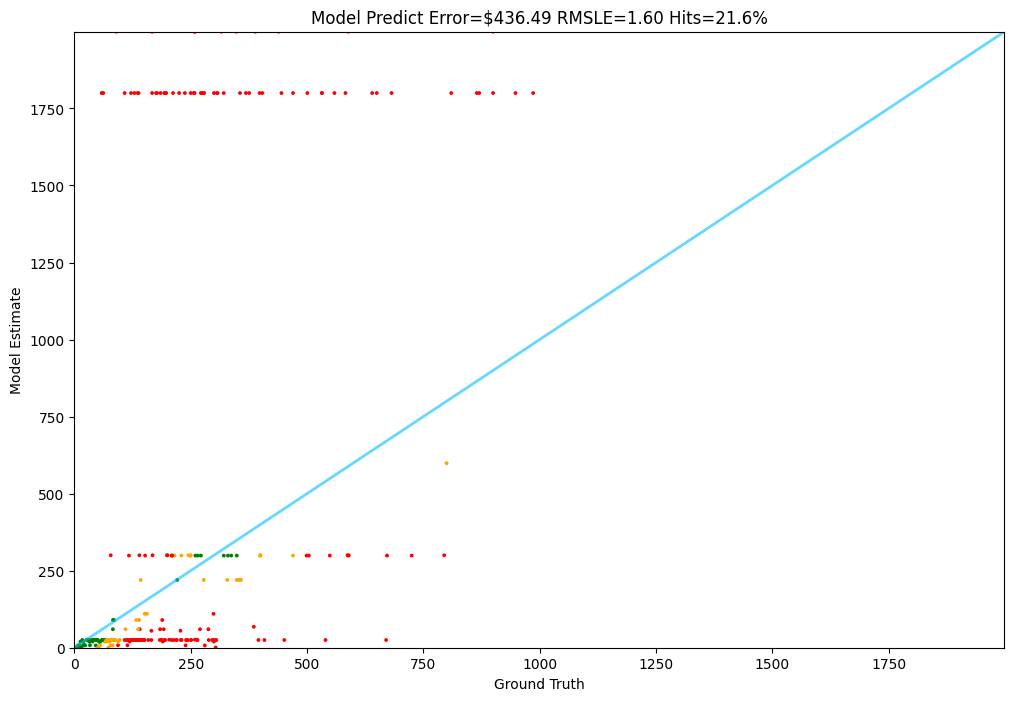

In [24]:
# test the model
Tester.test(model_predict,test)